## CCNSS 2018 Module 1: Neurons, synapses and networks
# Tutorial 3: Spike timing dependent plasticity
[source](https://colab.research.google.com/drive/1pE0nERUutXNIjCBQIWD_TdlE-mDLhtR1)

Please execute the cell below to initialise the notebook environment.

In [1]:
%autosave 0

import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import random                      # import basic random number generator functions

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

Autosave disabled


##Objectives
In your first (pre-course) tutorial, you implemented a LIF spiking neuron with a noisy input current. In this notebook we extend that model to implement spike timing dependent plasticity.

**Background paper:**  
- Song S, Miller K and Abott L (2000) Competitive Hebbian learning
through spike-timing-dependent synaptic plasticity. Nature Neurosci 3. 

**Extra reading:**  
- Sjostrom J and Gerstner W (2010) Spike-timing dependent plasticity. Scholarpedia: http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity


## Conductance based LIF model

We will extend the leaky integrate and fire model by adding synaptic conductances and Poisson inputs. The postsynaptic membrane potential is given by:

\begin{align}
&\tau\,\frac{dV}{dt}\ = E_{L} - V(t) + g_{ex}(t)(E_{ex}-V(t)) &\text{if }\quad V(t) \leq V_{th}\\
&V(t) = V_{r} &\text{otherwise}\\
\end{align}

These equations should look familiar (from the LIF neuron assignment). The only difference is that the synaptic input has now been replaced by an excitatory synaptic conductance, which is given by the following decaying exponential:

$$\tau_{syn} \frac{dg_{ex}}{dt} = -g_{ex} $$

When a spike occurs at presynaptic synapse $i$, the conductance will be updated as:

$$ g_{ex}(t) = g_{ex}(t) + \bar g_{max}$$

The variable $\bar g_{max}$ represents the peak amplitude for a unitary spike input. We will later modify this variable to we implement synaptic plasticity.

First, execute the cell below to set the simulation parameters.

In [2]:
t_max = 150e-3   # second
dt = 1e-3        # second
tau = 20e-3      # second
el = -60e-3      # volt
e_ex = 0         # volt
vr = -70e-3      # volt
vth = -50e-3     # volt
tau_syn = 5e-3    # second 
gbar_max = 0.015

**Exercise 1:** Fill in the following function  to generate Poisson distributed spike times for arbitrary firing rate $r$. Poisson spike times can be approximated by setting the probability of a spike occurring in a short time bin $\Delta t$ as the product of the firing rate and the time window $r \Delta t$ (for small $\Delta t$). Check your function by generating Poisson spike times for n=2000 "neurons" at 10 Hz each. Calculate the average firing rate across all neurons, and then plot a histogram of the firing rates over the neurons.

* **Note:** In the function `generate_Poisson_spikes`, initialise the presynaptic spike train using `np.zeros((n,len(t)), dtype=np.int)` to speed up the code.

150 10 2000
10.133333333333333
(2000, 150)


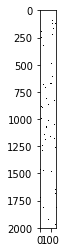

[2 2 1 ... 2 4 1]
(2000,)


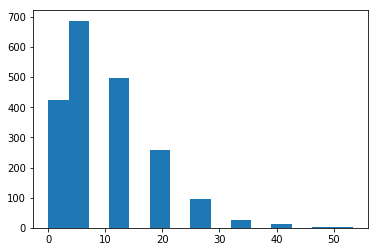

In [3]:
random.seed(0)

def generate_Poisson_spikes(t,rate,n):
    """ Generates poisson spike trains
    
    Arguments:
    t -- time
    rate -- firing rate (Hz)
    n -- number of spike trains
  
    Returns:
    pre_spike_train -- spike train matrix, ith row represents whether 
                       there is a spike in ith spike train over time
                       (1 if spike, 0 otherwise)
    """
    # insert your code here
    print(len(t), rate, n)
    pre_spike_train = np.random.rand(n, len(t))<(rate*dt)
    return pre_spike_train

# insert your code here
num_neurons = 2000

t = np.arange(0, t_max, dt)
spike_train = generate_Poisson_spikes(t, 10, num_neurons)
print(np.sum(spike_train)/num_neurons/(t_max/dt)/dt)
print(spike_train.shape)

plt.imshow(spike_train, cmap='Greys',  interpolation='nearest')
plt.show()

print(np.sum(spike_train, 1))
print(np.sum(spike_train, 1).shape)
plt.hist(np.sum(spike_train, 1)/t_max, bins=15)
plt.show()


**EXPECTED OUTPUT**
```
10.096666666666668
```

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E1.png)

**Exercise 2:** Fill in the function below to simulate the conductance based LIF model for a given set of presynaptic spike time inputs. To do this, you will need to discretise both $V(t)$ and $g_{ex}(t)$. This is equivalent to:
\begin{align}
&V[k+1] = V[k] + \frac{dt}{\tau} \left(E_L - V[k] + g_{ex}[k](E_{ex}-V[k])\right)\\
&g_{ex}[k+1] = g_{ex}[k] -\frac{dt}{\tau_{syn}} g_{ex}[k]
\end{align}
Don't forget to reset $V(t)\to V_r$ once it reaches threshold $V_{th}$, and set $g_{ex}(t) \to g_{ex}(t)+\bar g_{max}$ at every timepoint where there is a presynpatic spike. Then, simulate the model for 300 excitatory inputs, each firing at 10 Hz. Plot $V(t)$ and $g_{ex}(t)$, as well as the number of presynaptic spikes at each time point. Note that the latter two plots should be correlated.

150 10 300
150 300


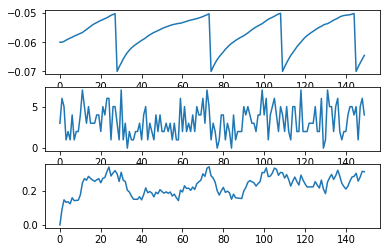

In [4]:
random.seed(0)

def simulate_postsynaptic_neuron(t,pre_spike_train):
    """ Simulate nonplastic postsynaptic neuron
  
    Arguments:
    t -- time
    pre_spike_train -- presynaptic spike train matrix, same length as t
  
    Returns:
    g_ex -- excitatory conductance
    v -- membrane potential
    """
    
    # insert your code here

    n = pre_spike_train.shape[0]
    run_len = pre_spike_train.shape[1]
    print(run_len, n)
    
    g_ex = np.empty(run_len)
    v = np.empty(run_len)
    
    g_ex[0] = 0
    v[0] = -0.06
    
    for index in range(run_len - 1):
        rindex = index + 1
        v[rindex] = v[index] + dt / tau * (el - v[index] + g_ex[index]*(e_ex-v[index]))
        g_ex[rindex] = g_ex[index] - dt / tau_syn * g_ex[index]
        
        if v[rindex] > vth:
            v[rindex] = vr
        g_ex[rindex]  += np.sum(pre_spike_train[:, rindex])*gbar_max
    
    
    return g_ex,v
  
# insert your code here
rate = 10
n = 300
t_max = 150e-3   # second
dt = 1e-3        # second
t = np.arange(0, t_max, dt)
pre_spike_train = generate_Poisson_spikes(t,rate,n)
g_ex, v = simulate_postsynaptic_neuron(t, pre_spike_train)
plt.subplot(3,1,1)
plt.plot(v)
plt.subplot(3,1,2)
plt.plot(np.sum(pre_spike_train, 0))
plt.subplot(3,1,3)
plt.plot(g_ex)

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E2.png)

## Spike timing dependent plasticity

Now we will incorporate STDP into the conductance based model. Models of STDP generally have a biphasic exponential decaying function. This means the change in weights is given by:

\begin{align}
& \Delta W = A_+ e^{ (t_{pre}-t_{post})/\tau_+}  \hspace{10mm} \text{if} \hspace{5mm}  t_{post} > t_{pre}\\
& \Delta W =  -A_- e^{- (t_{pre}-t_{post})/\tau_-}   \hspace{7mm} \text{if} \hspace{5mm} t_{post} < t_{pre}
\end{align}

This model captures potentiation when the presynaptic spike time occurs before the postsynaptic spike time, and depression if it occurs after. The parameters $A_+$ and $A_-$ determine the magnitude of LTP and LTD, and $\tau_{+}$ and $\tau{-}$ determine the temporal window.


Execute the following code to set the STDP parameters and plot the STDP function. For simplicity, we assume $\tau_{+} = \tau_{-} = \tau_{stdp}$.

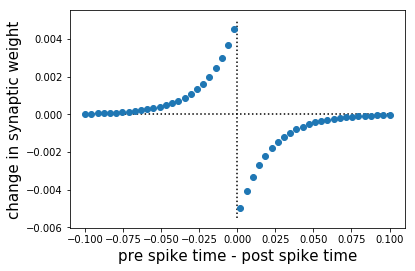

In [5]:
tau_stdp = 20e-3       # second
A_plus = 5e-3  
A_minus = A_plus*1.10


# Plot STDP function
time_diff = np.linspace(-5*tau_stdp,5*tau_stdp,50)
plt.figure()
plt.plot([-5*tau_stdp,5*tau_stdp],[0,0],'k',linestyle=':')
plt.plot([0,0],[-A_minus,A_plus],'k',linestyle=':')

for t in range(len(time_diff)):
  if time_diff[t] < 0:
    plt.plot(time_diff[t],A_plus*np.exp(time_diff[t]/tau_stdp),'C0o')
  else:
    plt.plot(time_diff[t],-A_minus*np.exp(-time_diff[t]/tau_stdp),'C0o')

plt.xlabel('pre spike time - post spike time',fontsize=15)
plt.ylabel('change in synaptic weight',fontsize=15)
plt.show()

## Keeping track of pre and postsynaptic spikes
In order to implement STDP, we first have to keep track of the pre and post synaptic spike times throughout our simulation. A simple way to do this is to define the following equation:
$$\tau_{-} \frac{dM}{dt} = -M$$
Whenever the postsynaptic neuron spikes, 
$$M(t) = M(t) - A_{-}$$
Then, $M(t)$ tracks the number of postsynaptic spikes over the timescale $\tau_{-}$. Similarly for each presynaptic spike,
$$\tau_{+} \frac{dP_i}{dt} = -P_i$$
Whenever the $i$th presynaptic neuron spikes,
$$P(t) = P(t) + A_{+}$$
The variables $M(t)$ and $P_i(t)$ are very similar to the equations for the synaptic conductances $g_i(t)$, except that they are used to keep track of pre and postsynaptic spike times on a much longer timescale. Note that $M(t)$ is always negative and $P_i(t)$ is always positive.  You can probably already guess that $M$ is used for LTD and $P_i$ for LTP because they are updated by $A_{minus}$ and $A_{plus}$, respectively. But since the equation for $P_i$ only depends on the presynaptic spike times, we wiill generate $P_i(t)$ before simulating the postsynaptic neuron and STDP.

**Exercise 3:** Fill in the following function to generate P from the presynaptic spike train. Test that this function works by simulating 5 inputs spiking at 10 Hz each, and plot both the spike times and $P_i(t)$. 

150 10 300
(300, 150)


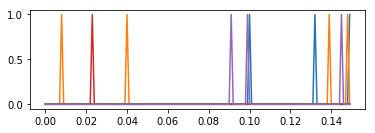

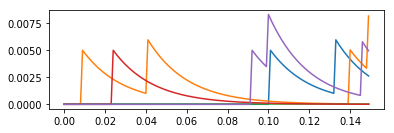

In [6]:
random.seed(0)

def generate_P(t,pre_spike_train):
    """ Generate P to track presynaptic spikes
  
  Arguments:
  t -- time
  pre_spike_train -- presynaptic spike train matrix, same length as t
  
  Returns:
  P -- matrix, ith row is P for the ith presynaptic input 
    """
    # insert your code here
    P = np.zeros(pre_spike_train.shape)
    n, run_len = pre_spike_train.shape
    
    
    for i in range(run_len-1):
        P[:,i+1] = P[:,i] - P[:, i]*dt/tau_stdp
        P[:,i+1] += pre_spike_train[:,i]*A_plus
    return P



# insert your code here
t_max = 150e-3   # second
dt = 1e-3        # second
t = np.arange(0, t_max, dt)
pre_spike_train = generate_Poisson_spikes(t,rate,n)
P = generate_P(t,pre_spike_train)
plt.subplot(2, 1, 1)
print(pre_spike_train.shape)
plt.plot(t, pre_spike_train[0,:])
plt.plot(t, pre_spike_train[1,:])
plt.plot(t, pre_spike_train[2,:])
plt.plot(t, pre_spike_train[3,:])
plt.plot(t, pre_spike_train[4,:])
plt.show()
plt.subplot(2, 1, 2)
plt.plot(t, P[0,:])
plt.plot(t, P[1,:])
plt.plot(t, P[2,:])
plt.plot(t, P[3,:])
plt.plot(t, P[4,:])

## Implementation of STDP

Finally, to implement STDP in spiking networks, we will change the value of the peak synaptic conductance based on the pre and post synaptic timing. Previously, we set the peak synaptic conductance to $\bar g_{max}$. Now, each synapse $i$ will have its own peak synaptic conductance $\bar g_i$, which will vary between $[0, \bar g_{max}]$, and will be modified depending on the pre and post synaptic timing. If presynaptic neuron $i$ spikes, its corresponding peak conductance is updated to:
$$\bar g_i = \bar g_i + M(t)\bar g_{max} $$
Note that $M(t)$ tracks the time since the last postsynaptic potential and is negative. So if the postsynaptic neuron spikes shortly before the presynaptic neuron, the above equation means that the peak conductance will decrease. On the other hand, if the postsynaptic neuron spikes, all conductances are updated according to:
$$\bar g_i = \bar g_i + P_i(t)\bar g_{max} $$
Again, $P_i(t)$ tracks the time since presynaptic neuron $i$ last spiked, and is positive. So this equation means that if the presynaptic neuron spikes before the postsynaptic neuron, its peak conductance will increase.

**Exercise 4:** Fill in the following code to implement STDP, by modifying the code from Exercise 2 and calling the ``generate_P``. Make sure that $\bar g_i$ never goes outside of its bounds. Check that this works by the simulating plastic postsynaptic neuron with 300 inputs firing at 10 Hz each. Plot $v(t)$, $M(t)$, $P_i(t)$, $\bar g_i(t)$, and $g_{ex}(t)$.


150 10 300
150 300


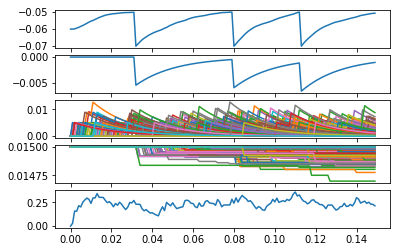

In [12]:
random.seed(0)

def simulate_postsynaptic_neuron_plastic(t,pre_spike_train):
    """Simulate a plastic neuron
    
    Arguments:
    t -- time
    pre_spike_train -- presynaptic spike train matrix, same length as t
  
    Returns:
    g_ex -- excitatory conductance
    gbar -- matrix, ith row is peak excitatory conductance 
            over time for ith presynaptic neuron
    P -- matrix, keeps track of presynaptic spikes
    M -- vector, keeps track of postsynaptic spikes
    v -- membrane potential
    """
    # insert your code here
    n = pre_spike_train.shape[0]
    run_len = pre_spike_train.shape[1]
    print(run_len, n)
    
    g_ex = np.zeros(run_len)
    gbar = np.zeros((n, run_len))
    P = np.zeros((n, run_len))
    v = np.zeros(run_len)
    M = np.zeros(run_len)
    
    g_ex[0] = 0
    v[0] = el
    gbar[:,0] = 0.015
    
    for i in range(run_len - 1):
        rindex = i + 1
        
        P[:,i+1] = P[:,i] - P[:, i]*dt/tau_stdp
        P[:,i+1] += pre_spike_train[:,i]*A_plus
        
        M[i+1] = M[i] - M[i]*dt/tau_stdp
        
        
        v[rindex] = v[i] + dt / tau * (el - v[i] + g_ex[i]*(e_ex-v[i]))
        g_ex[rindex] = g_ex[i] - dt / tau_syn * g_ex[i]
        
        if v[rindex] > vth:
            #print('post spike!!!!! with vth')
            v[rindex] = vr
            M[i+1] = M[i] - A_minus
            gbar[:,i+1] = gbar[:,i] + P[:,i]*gbar_max
        g_ex[rindex]  += np.sum(pre_spike_train[:, i]*gbar[:,i])
        
        gbar[:,i+1] = gbar[:,i] + pre_spike_train[:, i]*M[i]*gbar_max
        
    
    return g_ex,gbar,P,M,v

# insert your code here
t_max = 150e-3   # second
dt = 1e-3        # second
t = np.arange(0, t_max, dt)
n = 300
rate = 10
pre_spike_train = generate_Poisson_spikes(t,rate,n)
g_ex,gbar,P,M,v = simulate_postsynaptic_neuron_plastic(t,pre_spike_train)
plt.subplot(5, 1, 1)
plt.plot(t, v)
plt.subplot(5, 1, 2)
plt.plot(t, M)
plt.subplot(5, 1, 3)
for i in range(n):
    plt.plot(t, P[i,:])
plt.subplot(5, 1, 4)
for i in range(n):
    plt.plot(t, gbar[i, :])
plt.subplot(5, 1, 5)
plt.plot(t, g_ex)
plt.show()



**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E4.png)

**Exercise 5:** Execute the following cell to increase the presynaptic firing rate to 20 Hz and simulate the plastic postsynaptic neuron for 200s. This will take several minutes so this is a good time to take a short break. 

In [19]:
random.seed(0)

#t_max = 200; dt = 1e-3 
t_max = 2; dt = 1e-3
t = np.arange(0, t_max, dt)

rate = 20; n = 300; 
pre_spike_train = generate_Poisson_spikes(t,rate,n)
g_ex,gbar,P,M,v = simulate_postsynaptic_neuron_plastic(t,pre_spike_train)


2000 20 300
2000 300


Fill in the cell below to normalize $\bar g(t)$ by its maximum value and plot the trajectories for all presynaptic neurons (to better visualize all the traces, use `linewidth=.2`). Plot a histogram of the peak weights (as a fraction of $\bar g_{max}$) at the beginning of the STDP protocol, as well as halfway through, 2/3 of the way through, 3/4 of the way through, and at end. Is the system at steady state? 

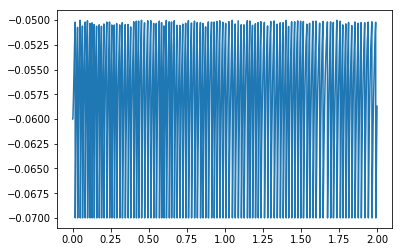

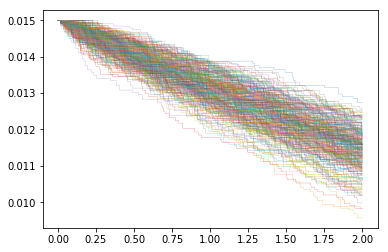

In [20]:
# insert your code here
plt.plot(t, v)
plt.show()

for i in range(n):
    plt.plot(t, gbar[i, :],linewidth=.2)
plt.show()


(https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E5a.png)
(https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E5b.png)





**Exercise 6:** Run the following cell to repeat the previous exercise, but now we will introduce a subset of correlated inputs by setting the first 10 presynaptic neurons to have the same spike times.

In [10]:
random.seed(0)

t_max = 200; dt = 1e-3 
t = np.arange(0, t_max, dt)

rate = 20; n = 300; 
pre_spike_train = generate_Poisson_spikes(t,rate,n)

for k in range(50):
  pre_spike_train[k,:] = pre_spike_train[0,:]

g_ex,gbar,P,M,v = simulate_postsynaptic_neuron_plastic(t,pre_spike_train)

200000 20 300
200000 300


Copy/paste the code from Exercise 5 into the cell below to produce the same plots of $\bar g_i(t)$ and the same histograms. What is happening and why is this different from the previous exercise?

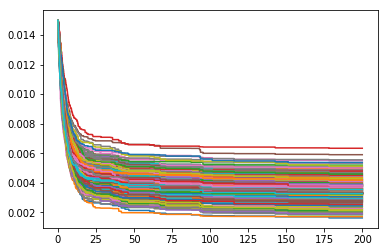

In [11]:
# insert your code here
for i in range(n):
    plt.plot(t, gbar[i, :])
plt.show()

**EXPECTED OUTPUT**

![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E6a.png)
![](https://github.com/ccnss/ccnss2018_students/raw/master/module1/figures/T2E6b.png)